In [1]:
# data preprossessing
from __future__ import unicode_literals, print_function, division
import numpy as np
from io import open
import unicodedata
import string
import re
import random
from sklearn.model_selection import train_test_split
# helper
import time
import math
# plot
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
# torch
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable

from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
from masked_cross_entropy import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_CUDA = True

## * Helper function

In [2]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

# cost_function plot
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

# 1. Data preparation

In [3]:
class voc:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: 'PAD', 1: 'SOS', 2: 'EOS'}
        self.n_words = 3  # Count PAD, SOS and EOS
        self.max_length = 1

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
    def addSentence(self, sentence):
        i = 0
        for word in sentence.split():
            self.addWord(word)
            i+=1
        if i > self.max_length:
            self.max_length = i    

## * Clean text: remove punctuations, truncate the length and group into pairs

In [4]:
# remove punctuations
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z]+", r" ", s)
    return s

In [5]:
def read_data(data_path):        
    '''
    Return cleaned a list of pairs, e.g. [[pair1, pair2], [pair3, pair4], ...]
    '''
    # Read the file and split into lines
    lines = open(data_path, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = []
    for i in range(0,len(lines),2):
        pairs.append([normalizeString(lines[i]), normalizeString(lines[i+1])])
    return pairs

In [6]:
# trim the pairs by max_length
def filterPair(p, MAX_LENGTH):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs, MAX_LENGTH):
    return [pair for pair in pairs if filterPair(pair, MAX_LENGTH)]

In [7]:
def prep_data(data_path, MAX_LENGTH):
    '''
    Return voc instance, and trimed and cleaned pairs
    '''
    pairs = read_data(data_path)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs, MAX_LENGTH)
    print("Trimmed to %s sentence pairs" % len(pairs))
    # initialize voc instance
    lang = voc()
    print("Counting words...")
    for pair in pairs:
        lang.addSentence(pair[0])
        lang.addSentence(pair[1])
    print("Counted words:")
    print(lang.n_words)
    return lang, pairs

In [10]:
# test things out
data_path = '../data/eminem.txt'
lang, pairs = prep_data(data_path, MAX_LENGTH = 20)
print(random.choice(pairs))

Read 3406 sentence pairs
Trimmed to 3127 sentence pairs
Counting words...
Counted words:
5532
['this boulder on my shoulder gets heavy and harda to hold', 'and this load is like the weight of the world']


## * Tensorization (pair -> split -> add EOS token -> tensor -> integer encoding)

In [8]:
# word to index
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split()]
# add EOS_token at the end of sentence
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    # convert indexes into torch.long datatype
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)
# split pair into input and target
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(lang, pair[0])
    target_tensor = tensorFromSentence(lang, pair[1])
    return (input_tensor, target_tensor)

## * Pretrained embeddings

In [9]:
# alternative way to import glove
# from torchnlp.word_to_vector import GloVe

def pretrained(glove_path):
    '''
    load pretrained glove and return it as a dictionary
    '''
    # dimension of import word2vec file
    glove = {}
    with open(glove_path,'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            glove[word] = coefs
    return glove

def embeds(glove_path, EMBEDDING_DIM, non_trainable=True):
    '''
    match pretrained embedding and dataset
    '''
    glove = pretrained(glove_path)
    embedding_matrix = np.zeros((lang.n_words, EMBEDDING_DIM)) # initialization
    # count words that appear only in the dataset. word_index.items() yields dict of word:index pair
    for word, ix in lang.word2index.items():
        embedding_vector = glove.get(word)
        if embedding_vector is not None:
            # words not found in glove matrix will be all-zeros.
            embedding_matrix[ix] = embedding_vector
    # change the datatype from numpy_array to torch_tensor
    weight = torch.FloatTensor(embedding_matrix)
    # convert to the embedding of pytorch
    embedding_matrix = nn.Embedding.from_pretrained(weight)
    # make it non-trainable
    if non_trainable:
        embedding_matrix.weight.requires_grad = False
    
    return embedding_matrix, glove

# Encoder-decoder

In [11]:
# Generic decoder
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # self.embedding = nn.Embedding(input_size, hidden_size) # from scratch
        self.embedding, _ = embeds(glove_path, EMBEDDING_DIM, True) # load pretrained embedding
        self.gru = nn.GRU(hidden_size, hidden_size)
    
    # this forward function only takes one sample
    def forward(self, input, hidden):
        # for one word, embedded vector in 3D tensor is reshaped into (1, 1, -1)
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [13]:
# Vanilla decoder
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

In [16]:
# Attention implemented decoder
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
#         nn.Module.__init__(self)
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        # self.embedding = nn.Embedding(self.output_size, self.hidden_size) # from sratch
        self.embedding, _ = embeds(glove_path, EMBEDDING_DIM, True) # load pretrained embedding
        # attention layer
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        # gru layer
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        # embedded layer
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        # attention layer
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1) # concat hidden unit and embedded vector
        # apply weights on encoder outputs
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        # concat embedded vector and weighted decoder output
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        # relu + gru
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        # softmax out
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

# Stochastic training

In [23]:
teacher_forcing_ratio = 0.5
# this function only trains on one pair

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, 
          decoder_optimizer, criterion, max_length=MAX_LENGTH):
    # reset memory state at the start of taking a new input
    encoder_hidden = encoder.initHidden()
    # cleanup encoder/decoder grads
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    # need to save encoder_outputs, so we initialized it as zero matrix first
    # encoder_outputs will be using to calculate attention weights
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    correct = 0
    total = 0

    for ei in range(input_length):
        # note that encoder_output is a vector with length = hidden_size
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        # append output to encoder_outputs
        encoder_outputs[ei] = encoder_output[0, 0]
    
    #################################################################################
    # decoder part
    # decoder_input starts with SOS_token
    decoder_input = torch.tensor([[SOS_token]], device=device)
    # first decoder_hidden = last encoder_hidden
    decoder_hidden = encoder_hidden
    
    # teacher forcing
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            # feed input into decoder which yields output, next hidden unit, decoder attention
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # obtain loss from optimizer
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
            # collect info for obtaining accuracy
            total +=1
            # greedy search
            topv, topi = decoder_output.data.topk(1)
            if topi == target_tensor[di]: correct +=1

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            # collect info for obtaining accuracy
            total +=1
            # greedy search
            topv, topi = decoder_output.data.topk(1)
            if topi == target_tensor[di]: correct +=1
            # break if EOS_token generated
            if decoder_input.item() == EOS_token:
                break
    
    # accumulate gradient by virtue of backpropagation
    loss.backward()
    # update weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length, correct, total

## * Validation

In [25]:
def validation(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    '''
    This function will run on one sample
    input_tensor, target_tensor -> integer encoded
    encoder, decoder -> instantiated encoder and decoder
    criterion -> will be given in trainIter
    max_length -> required to build encoder_outputs
    
    returns: averaged loss, correctly predicted words, total words predicted
    '''
    loss = 0
    correct = 0
    
    with torch.no_grad():
        # prepare input from encoder end
        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)
        encoder_hidden = encoder.initHidden()
        # initiate output matrix from encoder
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            # append output to encoder_outputs matrix
            encoder_outputs[ei] += encoder_output[0, 0]
            
        ########################################################################
        # decoder part
        # first input of decoder is SOS_token
        decoder_input = torch.tensor([[SOS_token]], device=device)
        # hidden unit is the last hidden unit from encoder
        decoder_hidden = encoder_hidden
        # for loop for each word in the sequence
        for di in range(target_length):
            decoder_output, decoder_hidden, _ = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # a.topk(n) yields top n items from a and corresponding index of items
            # greedy search output
            topv, topi = decoder_output.data.topk(1)
            decoder_input = topi.squeeze().detach()
            if topi == target_tensor[di]: correct +=1
            # accumulate loss
            loss += criterion(decoder_output, target_tensor[di])
            # .item() convert datatype from torch tensor to int
            if topi.item() == EOS_token: break
            
        return loss.item()/target_length, correct, target_length

def validIter(testing_pairs, encoder, decoder, criterion):
    '''
    testing_pairs -> integer encoded input
    encoder/decoder -> instantiated encoder/decoder
    criterion -> defined in trainIter
    
    returns: averaged loss, averaged accuracy
    '''
    correct_total = 0
    total_total = 0
    loss_total = 0
    data_size = len(testing_pairs)
    
    for itr in range(data_size):

        pair = testing_pairs[itr]
        input_tensor = pair[0]
        target_tensor = pair[1]
        # obtain loss from train function
        loss, correct, total = validation(input_tensor, target_tensor, encoder,
                     decoder, criterion, max_length=MAX_LENGTH)
        # accumulate metrics
        correct_total += correct
        total_total += total
        loss_total += loss
    
    return loss_total/data_size, correct_total/total_total * 100

## * Iteration of train

In [37]:
def trainIters(encoder, decoder, epochs=2, learning_rate=0.01):
    
    # store loss of train and test
    loss_array_train, loss_array_test = [], []
    
    # create optimizer for encoder and decoder
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    
    # train/test split
    pairs_train, pairs_test = train_test_split(pairs, test_size=0.2, random_state=666)
    # randomly select pairs from training set and have them integer encoded
    # epoch is meaningless in this case
    # training_pairs = [tensorsFromPair(random.choice(pairs_train)) for i in range(n_iters)]    
    training_pairs = [tensorsFromPair(pair) for pair in pairs_train]
    testing_pairs = [tensorsFromPair(pair) for pair in pairs_test]

    # negative log-likelihood
    # criterion = nn.NLLLoss()
    criterion = nn.CrossEntropyLoss()
    
    batch_size = 20
    
    for epoch in range(epochs):
        print('Training on epoch_{}'.format(epoch+1))
        
#         # loss and acc of training set
#         loss_train, acc_train = batchIter(training_pairs, encoder, decoder, encoder_optimizer, 
#         decoder_optimizer, criterion, batch_size, max_length=MAX_LENGTH)
        
        # loss and acc of testing set 
        loss_test, acc_test = validIter(testing_pairs, encoder, decoder, criterion)            
        
        # append losses to arrays
        loss_array_train.append(loss_test)
        loss_array_test.append(loss_test)
        # verbose
        print('<= Done! => loss_train:{}, acc_train:{}%, loss_test:{}, acc_test:{}%'
              .format(round(loss_test,2), round(acc_test, 2), round(loss_test,2), round(acc_test, 2)))

    showPlot(loss_array_train)
    showPlot(loss_array_test)

# Run model

In [22]:
glove_path = 'glove.6B.50d.txt'
EMBEDDING_DIM = 50
MAX_LENGTH = 20

PAD_token = 0
SOS_token = 1
EOS_token = 2
hidden_size = EMBEDDING_DIM

lang, pairs = prep_data('eminem.txt', MAX_LENGTH = 20)

Read 3406 sentence pairs
Trimmed to 3127 sentence pairs
Counting words...
Counted words:
5532


In [139]:
encoder_test = EncoderRNN(lang.n_words, hidden_size).to(device)
decoder_test = AttnDecoderRNN(hidden_size, lang.n_words, dropout_p=0.1).to(device)

Training on epoch_1
<= Done! => loss_train:8.66, acc_train:0.0%, loss_test:8.66, acc_test:0.0%
Training on epoch_2
<= Done! => loss_train:8.66, acc_train:0.0%, loss_test:8.66, acc_test:0.0%


<Figure size 432x288 with 0 Axes>

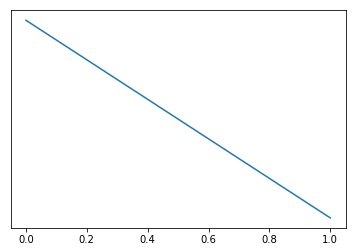

<Figure size 432x288 with 0 Axes>

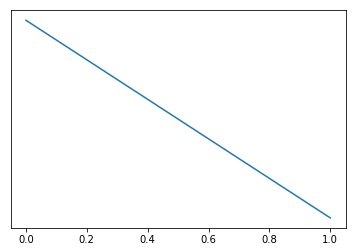

In [38]:
trainIters(encoder_test, decoder_test, 2, 0.01)

# Evaluation

In [25]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        # prepare input from encoder end
        input_tensor = tensorFromSentence(lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        # initiate output matrix from encoder
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            # append output to encoder_outputs matrix
            encoder_outputs[ei] += encoder_output[0, 0]
        # first input of decoder is SOS_token
        decoder_input = torch.tensor([[SOS_token]], device=device)
        # hidden unit is the last hidden unit from encoder
        decoder_hidden = encoder_hidden
        
        # initialize output list from decoder
        decoded_words = []
        # initialize attention matrix
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # append attention
            decoder_attentions[di] = decoder_attention.data
            # a.topk(n) yields top n items from a and corresponding index of items
            # greedy search output
            topv, topi = decoder_output.data.topk(1)
            # .item() convert datatype from torch tensor to int
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                # index to word
                decoded_words.append(lang.index2word[topi.item()])
            # new input is the output from last word
            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]


In [26]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

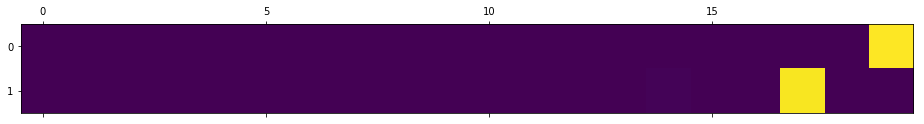

In [208]:
output_words, attentions = evaluate(encoder1, attn_decoder1, "i am rap god")
plt.matshow(attentions.numpy())

In [27]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

input = i am rap god
output = i <EOS>


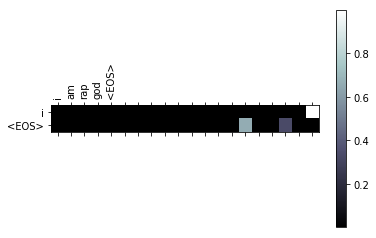

In [212]:
evaluateAndShowAttention("i am rap god")

In [ ]:
SOS_token = 1
    batch_size = input_batches.size(1)
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Run words through encoder
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size))
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder
    
    # max_length of batch data
    max_target_length = max(target_lengths)
    all_decoder_outputs = Variable(torch.zeros(max_target_length, batch_size, decoder.output_size))

    # Move new Variables to CUDA
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        all_decoder_outputs = all_decoder_outputs.cuda()

    # Run through decoder one time step at a time
    for t in range(max_target_length):
        decoder_output, decoder_hidden, decoder_attn = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )

        all_decoder_outputs[t] = decoder_output
        decoder_input = target_batches[t] # Next input is current target

    # Loss for batch data
    loss = masked_cross_entropy(
    all_decoder_outputs.transpose(0, 1).contiguous(),
    target_batches.transpose(0, 1).contiguous(),
    target_lengths)
    
    # accumulate gradients
    loss.backward()
    
    # Clip gradient norms to prevent exploding gradient issue
    ec = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    dc = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Update parameters with optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item(), ec, dc